In [1]:
import warnings
warnings.simplefilter(action='ignore')

In [2]:
import scanpy as sc
import torch
import scarches as sca
import matplotlib.pyplot as plt
import numpy as np

In [3]:
sc.settings.set_figure_params(dpi=200, frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

### Download Dataset and split into reference dataset and query dataset

In [186]:
adata = sc.read('kang_count.h5ad')

In [187]:
sca.add_annotations(adata, 'c2.cp.reactome.v4.0.symbols.gmt', min_genes=12)

In [188]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [189]:
adata.obs['study'] = 'Kang'

In [190]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    flavor="seurat_v3",
    subset=True)

In [191]:
select_terms = adata.varm['I'].sum(0)>12

In [192]:
adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()

In [193]:
adata.varm['I'] = adata.varm['I'][:, select_terms]

In [194]:
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

In [195]:
rm_in_terms = ['INTERFERON_SIGNALING', 'CYTOKINE_SIGNALING_IN_IMMUNE_S', 'INTERFERON_ALPHA_BETA_SIGNALIN']
ix_f = []
for t in rm_in_terms:
    ix_f.append(adata.uns['terms'].index(t))

In [196]:
#genes_rm = {}
#for i, term in enumerate(rm_in_terms):
#    term_genes = adata.varm['I'][:, ix_f[i]]
#    sz_rm = int(term_genes.sum() * 0.15)
#    sel_rm = np.random.choice(np.where(term_genes)[0], sz_rm, replace=False)
#    genes_rm[term] = sel_rm
#    term_genes[sel_rm] = 0

In [197]:
top_ifn_genes = ['IFIT3', 'IFIT1', 'IFIT2', 'MX1', 'HERC5', 'EIF2AK2', 'IFI6', 'IFNGR2',
                 'ISG20', 'MX2', 'MT2A', 'IFNG', 'DDX58', 'OAS3', 'OAS2', 'ISG15',
                 'SOCS1', 'OAS1', 'KPNA2', 'OASL']

In [198]:
top_ifn_cyt_intersect = ['IFIT1', 'IFIT2', 'IFIT3', 'IFNGR2', 'KPNA2']

In [199]:
genes_rm = {}
for i, term in enumerate(rm_in_terms):
    term_genes = adata.varm['I'][:, ix_f[i]]
    sel_rm = np.isin(adata.var_names, top_ifn_cyt_intersect)
    genes_rm[term] = sel_rm
    term_genes[sel_rm] = 0

### Create TRVAE model and train it on reference dataset

In [200]:
intr_cvae = sca.models.TRVAE(
    adata=adata,
    condition_key='study',
    hidden_layer_sizes=[256, 256, 256],
    use_mmd=False,
    recon_loss='nb',
    mask=adata.varm['I'].T,
    use_decoder_relu=False,
    n_ext_decoder=0,
    n_expand_encoder=0,
    soft_mask=True,
    use_hsic=False,
    hsic_one_vs_all=False
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1981 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 267
Decoder Architecture:
	Cond layer in, ext, cond, out and :  267 0 1 1981
	with soft mask.


In [201]:
ALPHA = 0.7

In [202]:
OMEGA = None

In [203]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=200, 
    alpha_epoch_anneal=100, 
    alpha=ALPHA, 
    omega=OMEGA,
    alpha_l1=0.3,
#    alpha_l1_epoch_anneal=50,
    gamma_ext=None,
    gamma_epoch_anneal=None,
    alpha_kl=0.06,
    beta=None,
    weight_decay=0., 
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    print_n_deactive=True,
    seed=2020
)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.4414
-------------------
 |--------------------| 0.5%  - epoch_loss:  543.11 - epoch_recon_loss:  543.11 - epoch_kl_loss:  398.86 - val_loss:  474.51 - val_recon_loss:  474.51 - val_kl_loss:  710.85
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.5062
-------------------
 |--------------------| 1.0%  - epoch_loss:  467.26 - epoch_recon_loss:  466.52 - epoch_kl_loss: 1236.83 - val_loss:  460.14 - val_recon_loss:  459.00 - val_kl_loss: 1891.43
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.5279
-------------------
 |--------------------| 1.5%  - epoch_loss:  460.79 - epoch_recon_loss:  457.93 - epoch_kl_loss: 2378.79 - val_loss:  453.84 - val_recon_loss:  450.55 - val_kl_loss: 2744.21
Number of deactivated terms: 1
-------------------
Share of deactivated inactive genes: 0.6851
-------------------
 |----------------

Share of deactivated inactive genes: 0.9266
-------------------
 |██------------------| 14.5%  - epoch_loss:  425.51 - epoch_recon_loss:  413.91 - epoch_kl_loss:  690.81 - val_loss:  427.22 - val_recon_loss:  415.43 - val_kl_loss:  701.71
Number of deactivated terms: 30
-------------------
Share of deactivated inactive genes: 0.9227
-------------------
 |███-----------------| 15.0%  - epoch_loss:  425.89 - epoch_recon_loss:  414.16 - epoch_kl_loss:  673.91 - val_loss:  427.20 - val_recon_loss:  415.76 - val_kl_loss:  657.34
Number of deactivated terms: 19
-------------------
Share of deactivated inactive genes: 0.9220
-------------------
 |███-----------------| 15.5%  - epoch_loss:  423.72 - epoch_recon_loss:  411.95 - epoch_kl_loss:  654.13 - val_loss:  426.46 - val_recon_loss:  414.73 - val_kl_loss:  651.65
Number of deactivated terms: 26
-------------------
Share of deactivated inactive genes: 0.9199
-------------------
 |███-----------------| 16.0%  - epoch_loss:  425.34 - epoch_re

-------------------
 |█████---------------| 28.5%  - epoch_loss:  421.26 - epoch_recon_loss:  408.61 - epoch_kl_loss:  376.68 - val_loss:  420.24 - val_recon_loss:  407.96 - val_kl_loss:  365.70
Number of deactivated terms: 7
-------------------
Share of deactivated inactive genes: 0.9042
-------------------
 |█████---------------| 29.0%  - epoch_loss:  418.99 - epoch_recon_loss:  406.34 - epoch_kl_loss:  369.85 - val_loss:  418.84 - val_recon_loss:  406.24 - val_kl_loss:  368.58
Number of deactivated terms: 5
-------------------
Share of deactivated inactive genes: 0.9022
-------------------
 |█████---------------| 29.5%  - epoch_loss:  417.52 - epoch_recon_loss:  404.91 - epoch_kl_loss:  362.49 - val_loss:  419.27 - val_recon_loss:  406.76 - val_kl_loss:  359.57
Number of deactivated terms: 2
-------------------
Share of deactivated inactive genes: 0.8996
-------------------
 |██████--------------| 30.0%  - epoch_loss:  417.87 - epoch_recon_loss:  405.20 - epoch_kl_loss:  357.92 - va

 |████████------------| 42.5%  - epoch_loss:  416.83 - epoch_recon_loss:  403.63 - epoch_kl_loss:  261.82 - val_loss:  418.58 - val_recon_loss:  405.56 - val_kl_loss:  258.48
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8941
-------------------
 |████████------------| 43.0%  - epoch_loss:  416.63 - epoch_recon_loss:  403.38 - epoch_kl_loss:  259.84 - val_loss:  417.45 - val_recon_loss:  404.22 - val_kl_loss:  259.52
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8943
-------------------
 |████████------------| 43.5%  - epoch_loss:  416.38 - epoch_recon_loss:  403.11 - epoch_kl_loss:  257.14 - val_loss:  418.24 - val_recon_loss:  405.35 - val_kl_loss:  249.78
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8995
-------------------
 |████████------------| 44.0%  - epoch_loss:  415.48 - epoch_recon_loss:  402.24 - epoch_kl_loss:  253.75 - val_loss:  418.33 - va

 |███████████---------| 56.5%  - epoch_loss:  416.98 - epoch_recon_loss:  404.43 - epoch_kl_loss:  209.21 - val_loss:  415.53 - val_recon_loss:  403.17 - val_kl_loss:  206.07
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8998
-------------------
 |███████████---------| 57.0%  - epoch_loss:  415.72 - epoch_recon_loss:  403.20 - epoch_kl_loss:  208.78 - val_loss:  415.87 - val_recon_loss:  403.48 - val_kl_loss:  206.58
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8966
-------------------
 |███████████---------| 57.5%  - epoch_loss:  414.68 - epoch_recon_loss:  402.22 - epoch_kl_loss:  207.58 - val_loss:  417.65 - val_recon_loss:  405.33 - val_kl_loss:  205.40
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8972
-------------------
 |███████████---------| 58.0%  - epoch_loss:  413.98 - epoch_recon_loss:  401.54 - epoch_kl_loss:  207.32 - val_loss:  416.20 - va

 |██████████████------| 70.5%  - epoch_loss:  410.82 - epoch_recon_loss:  398.84 - epoch_kl_loss:  199.64 - val_loss:  415.44 - val_recon_loss:  403.55 - val_kl_loss:  198.23
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8971
-------------------
 |██████████████------| 71.0%  - epoch_loss:  411.58 - epoch_recon_loss:  399.64 - epoch_kl_loss:  199.01 - val_loss:  414.65 - val_recon_loss:  402.67 - val_kl_loss:  199.78
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8959
-------------------
 |██████████████------| 71.5%  - epoch_loss:  413.58 - epoch_recon_loss:  401.60 - epoch_kl_loss:  199.73 - val_loss:  414.70 - val_recon_loss:  402.75 - val_kl_loss:  199.15
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8958
-------------------
 |██████████████------| 72.0%  - epoch_loss:  412.70 - epoch_recon_loss:  400.73 - epoch_kl_loss:  199.43 - val_loss:  414.73 - va

 |████████████████----| 84.5%  - epoch_loss:  412.59 - epoch_recon_loss:  400.81 - epoch_kl_loss:  196.42 - val_loss:  412.98 - val_recon_loss:  401.28 - val_kl_loss:  194.92
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8930
-------------------
 |█████████████████---| 85.0%  - epoch_loss:  409.82 - epoch_recon_loss:  398.07 - epoch_kl_loss:  195.82 - val_loss:  413.79 - val_recon_loss:  402.04 - val_kl_loss:  195.88
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8931
-------------------
 |█████████████████---| 85.5%  - epoch_loss:  410.80 - epoch_recon_loss:  399.04 - epoch_kl_loss:  195.94 - val_loss:  414.27 - val_recon_loss:  402.53 - val_kl_loss:  195.63
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8920
-------------------
 |█████████████████---| 86.0%  - epoch_loss:  412.19 - epoch_recon_loss:  400.36 - epoch_kl_loss:  197.24 - val_loss:  414.64 - va

 |███████████████████-| 98.5%  - epoch_loss:  411.66 - epoch_recon_loss:  399.91 - epoch_kl_loss:  195.76 - val_loss:  413.99 - val_recon_loss:  402.27 - val_kl_loss:  195.44
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8873
-------------------
 |███████████████████-| 99.0%  - epoch_loss:  412.74 - epoch_recon_loss:  400.96 - epoch_kl_loss:  196.31 - val_loss:  413.23 - val_recon_loss:  401.53 - val_kl_loss:  194.92
ADJUSTED LR

Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8889
-------------------
 |███████████████████-| 99.5%  - epoch_loss:  409.91 - epoch_recon_loss:  398.20 - epoch_kl_loss:  195.21 - val_loss:  414.46 - val_recon_loss:  402.73 - val_kl_loss:  195.50
Number of deactivated terms: 0
-------------------
Share of deactivated inactive genes: 0.8922
-------------------
 |████████████████████| 100.0%  - epoch_loss:  410.30 - epoch_recon_loss:  398.54 - epoch_kl_loss:  196.05 - val_loss

In [204]:
inactive_idx = ~intr_cvae.model.decoder.nonzero_terms()

In [205]:
terms = adata.uns['terms'].copy()

In [206]:
print('Inactive terms:')
[term for i, term in enumerate(terms) if inactive_idx[i]]

Inactive terms:


[]

In [207]:
MEAN = False

In [208]:
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN)[:, ~inactive_idx]

In [209]:
sc.pp.neighbors(adata, use_rep='X_cvae')

In [210]:
sc.tl.umap(adata)

... storing 'study' as categorical


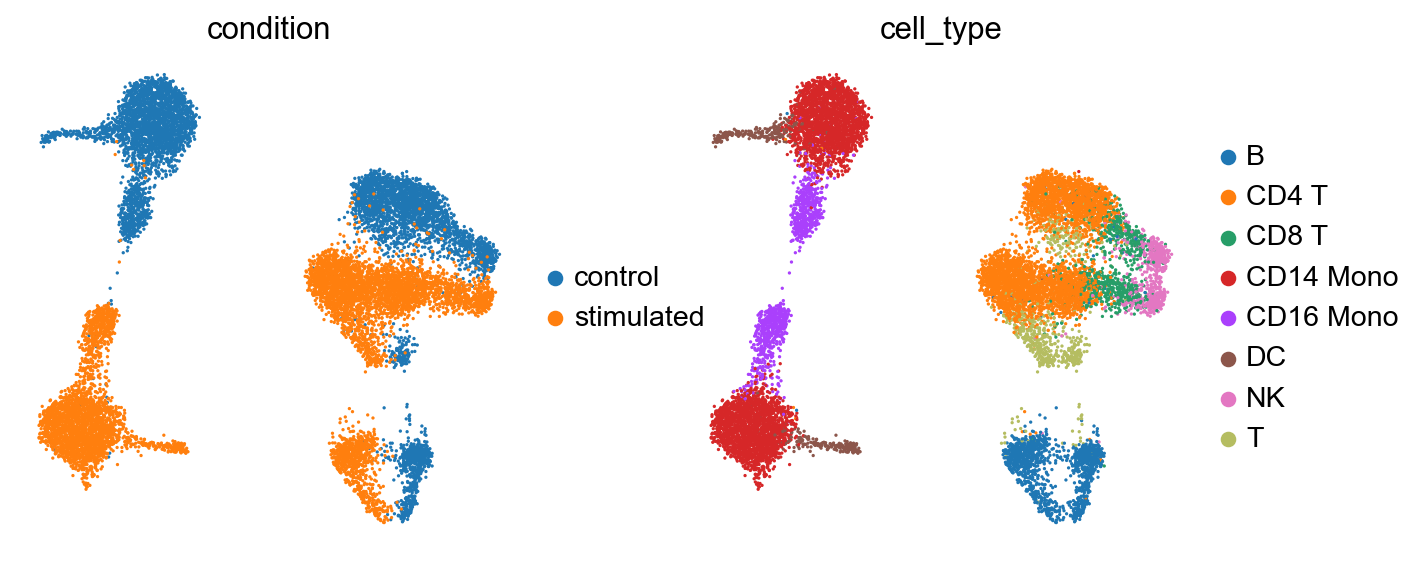

In [211]:
sc.pl.umap(adata, color=['condition', 'cell_type'], frameon=False)

In [212]:
scores_cond = intr_cvae.latent_enrich('condition', comparison="control", adata=adata, n_perm=7000)

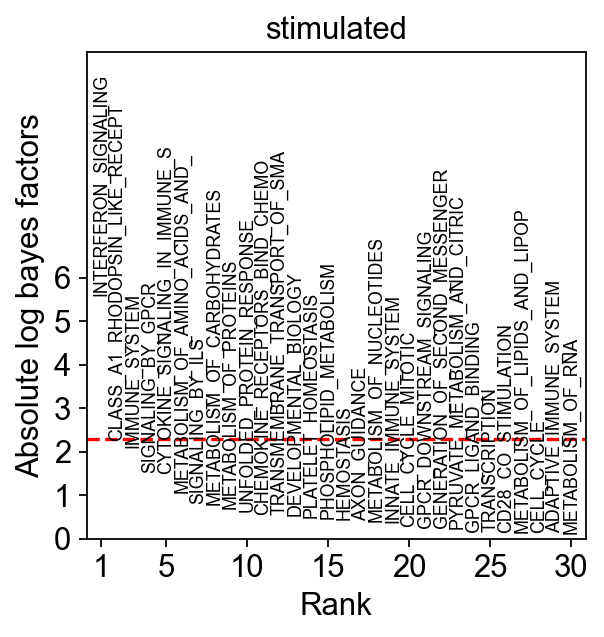

In [213]:
fig = sca.plotting.plot_abs_bfs(scores_cond, np.array(adata.uns['terms']), keys='stimulated', yt_step=1, fontsize=8, scale_y=2)

In [214]:
for i, ix in enumerate(ix_f):
    tname = rm_in_terms[i]
    print(tname)
    term = intr_cvae.model.decoder.L0.expr_L.weight.data[:, ix].abs().cpu().numpy()
    srt = np.argsort(term)[::-1]
    term = term > 0
    genes_from_term = np.isin(adata.var_names[srt[:20]], adata.var_names[adata.varm['I'][:, ix].astype(bool)]).sum()
    print('Total size before training:', adata.varm['I'][:, ix].sum())
    print('Total size after training:', term.sum().item())
    print('Genes from the term in top 20:', genes_from_term)
    print('Numbr of deleted genes:', genes_rm[tname].sum())
    print('Recovered genes number:', term[genes_rm[tname]].sum().item())
    print('Recovered in top 20:', np.isin(srt[:20], np.where(genes_rm[tname])[0]).sum())

INTERFERON_SIGNALING
Total size before training: 81
Total size after training: 1002
Genes from the term in top 20: 16
Numbr of deleted genes: 5
Recovered genes number: 4
Recovered in top 20: 3
CYTOKINE_SIGNALING_IN_IMMUNE_S
Total size before training: 137
Total size after training: 893
Genes from the term in top 20: 19
Numbr of deleted genes: 5
Recovered genes number: 5
Recovered in top 20: 0
INTERFERON_ALPHA_BETA_SIGNALIN
Total size before training: 30
Total size after training: 165
Genes from the term in top 20: 17
Numbr of deleted genes: 5
Recovered genes number: 2
Recovered in top 20: 1


In [73]:
#intr_cvae.save('intr_cvae_nb_mmd_beta_15')